# LSTM part-of-speech tagging for the French Treebank: 

This notebook trains a part-of-speech tagger for the French Treebank using a vanilla bi-direction LSTM network.

Run the following cell to load the Keras packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)

Using TensorFlow backend.


### Read the TLGbank file

In [ ]:
# very small initial part of corpus (only file aa1)
# X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('aa1.txt')

In [2]:
# small initial part of corpus (files aa1, aa2, ab2 and ae1)
# number of sentences, train: 1195, test: 398, dev: 399  
# X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('aa1_ae1.txt')

In [53]:
# entire corpus
# number of sentences, train: 9449, test: 3150, dev: 3150
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('m2.txt')

In [54]:
numClasses = len(partsofspeech2)+1
numSuperClasses = len(superset)+1

print()
print("Longest sentence   : ", maxLen)
print("Number of POS tags : ", numClasses)
print("Number of supertags: ", numSuperClasses)



Longest sentence   :  266
Number of POS tags :  32
Number of supertags:  891


## 1. Split the input into train/dev/test

Split the full training set into 60% train, 20% dev and 20% test.

In [55]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_train, Y_testdev = train_test_split(X, Y2, test_size=0.4)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_testdev, Y_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)


Train:  (9449,)
Test:   (3150,)
Dev:    (3150,)


## 2. Create auxiliary mappings

Create mappings from supertags and the two sets of part-of-speech tags to integers and back.

In [56]:
# create mapping for the two POS tagset and for the supertags

super_to_index, index_to_super = indexify(superset)
pos1_to_index, index_to_pos1 = indexify(partsofspeech1)
pos2_to_index, index_to_pos2 = indexify(partsofspeech2)
print(pos2_to_index)

{'PRO:POS': 1, 'VER:ppre': 2, 'PRO:IND': 3, 'VER:pres': 4, 'DET:POS': 5, 'SYM': 6, 'PRO:DEM': 7, 'VER:subp': 8, 'VER:impe': 9, 'NUM': 10, 'VER:futu': 11, 'PUN:cit': 12, 'DET:ART': 13, 'PRP': 14, 'PRP:det': 15, 'VER:cond': 16, 'NAM': 17, 'ABR': 18, 'VER:impf': 19, 'PUN': 20, 'KON': 21, 'PRO:REL': 22, 'VER:infi': 23, 'NOM': 24, 'ADJ': 25, 'PRO:PER': 26, 'PRO': 27, 'VER:pper': 28, 'VER:simp': 29, 'ADV': 30, 'INT': 31}


## 3. Obtain the word vector information

We are using a shell call to the compiled fastText code to produce a file _vectors.txt_ with the relevant vectors. 

### 3.1. Feature vectors

#### Suffixes

In [6]:
french_suffixes = read_suffixes('suffixes.txt')
print(len(french_suffixes))

203


In [7]:
suffix_vector("seraient", french_suffixes)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

#### Manually designed features

In [8]:
print(word_features("ABCD"))
print(word_features("Abcd"))
print(word_features("1234"))
print(word_features("*%"))
print(word_features("Ab-cd"))
print(word_features("-t-il"))
print(word_features("Contre"))
print(word_features("dans"))
print(word_features("anti-"))
print(word_features("et"))
print(word_features("ou"))
print(word_features("-t-il"))
print(word_features("-il"))
print(word_features("-tu"))
print(word_features("eussent"))

[ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

### 3.2. Sending the vocabulary through the fasttext executable

Write the vocabulary to an output file, then pass it to the fastText executable to produce the relevant word embeddings for our text. Since the fastText model is over 5 Gb, the shell call can take some time.

In [9]:
with open("vocab.txt", 'w') as vocab_file:
    for w in vnorm:
        print(w, file=vocab_file)

Shell call to `fasttext` for my Macbook Air

In [ ]:
!/Users/moot/Software/fastText-master/fasttext print-word-vectors /Users/moot/Corpus/wiki.fr/wiki.fr.bin < vocab.txt > vectors.txt

Shell call to `fasttest` for my Macbook Pro, with `wiki.fr.bin` on external drive

In [ ]:
!/Users/moot/Software/fastText-master/fasttext print-word-vectors /Volumes/LaCie/Corpus/fastText/wiki/wiki.fr.bin < vocab.txt > vectors.txt

#### Combine all vector information

Combined all information from fasttext, suffixes, manually selected features and the features for digits (which are not in fasttext) to produce combined feature vectors for all words 

In [57]:
word_to_index, index_to_word, word_to_vec_map = read_vecs('vectors.txt', vnorm, vocabulary)

### 3.3. The Embedding layer

In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, we create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras, and initialize it with the fastTeX vectors loaded earlier in the notebook. 

The `Embedding()` layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

We first convert all our training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence. 

**TODO**: I'd like try if it makes any difference to add the </s> end tag to the end of each sentence. 

Run the following cell to check what `sentences_to_indices()` does, and check your results.

In [58]:
sentences_to_indices(X_train, word_to_index, maxLen)

array([[  1.25340000e+04,   1.82240000e+04,   1.29310000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.83460000e+04,   2.27170000e+04,   3.14190000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.29150000e+04,   2.64000000e+04,   9.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.82640000e+04,   2.32960000e+04,   1.55840000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.38090000e+04,   3.41290000e+04,   2.83940000e+04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.93640000e+04,   2.76210000e+04,   1.75100000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

We now build the `Embedding()` layer for use with Keras, using pre-trained word vectors. After this layer is built, we can pass the output of `sentences_to_indices()` to it as an input, and the `Embedding()` layer will return the word embeddings for a sentence. 

We use the following steps:
1. Initialize the embedding matrix as a numpy array of zeroes with the correct shape.
2. Fill in the embedding matrix with all the word embeddings extracted from `word_to_vec_map`.
3. Define Keras embedding layer. Use [Embedding()](https://keras.io/layers/embeddings/). Be sure to make this layer non-trainable, by setting `trainable = False` when calling `Embedding()`. If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings. 
4. Set the embedding weights to be equal to the embedding matrix 

In [59]:

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 2                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["est"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=False,mask_zero=True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [60]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][2][1] =", embedding_layer.get_weights()[0][2][1])

weights[0][2][1] = 0.19175


**Expected Output**:

<table>
    <tr>
        <td>
            **weights[0][2][1] =**
        </td>
        <td>
           0.19175
        </td>
    </tr>
</table>

## 4. Building the Part-of-Speech tagger

We now build the POS-tagger model using the previously built enbedding layer and feed its output to a bidirectional LSTM network with 128 states in each direction. 



In [61]:
# POS_model

def POS_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    X = BatchNormalization()(X)
    Y = Dropout(0.5)(X)
    # Add a (time distributed) Dense layer followed by a softmax activation
    Y = TimeDistributed(Dense(numClasses, activation='softmax'))(Y)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=Y)
        
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose `max_len = 10`.  You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [62]:
model = POS_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 266)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 266, 663)          23596170  
_________________________________________________________________
lstm_4 (LSTM)                (None, 266, 128)          405504    
_________________________________________________________________
batch_normalization_3 (Batch (None, 266, 128)          512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 266, 128)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 266, 32)           4128      
Total params: 24,006,314
Trainable params: 409,888
Non-trainable params: 23,596,426
__________________________________________________________

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [63]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [64]:
X_train_indices = lists_to_indices(X_train, word_to_index, maxLen)
Y_train_indices = lists_to_indices(Y_train, pos2_to_index, maxLen)
Y_train_oh = to_categorical(Y_train_indices, num_classes=numClasses)

In [65]:
print(Y_train_indices[1])
print(Y_train_oh[1])

[  2.  13.  24.  25.  14.  13.  17.  20.  13.  24.   4.  15.  24.  25.  14.
  13.  24.  15.  24.  14.  24.  20.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.  

In [66]:
X_dev_indices = lists_to_indices(X_dev, word_to_index, max_len = maxLen)
Y_dev_indices = lists_to_indices(Y_dev, pos2_to_index, max_len = maxLen)
Y_dev_oh = to_categorical(Y_dev_indices, num_classes = numClasses)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [67]:
history = model.fit(X_train_indices, Y_train_oh, epochs = 30, batch_size = 32, shuffle=True, validation_data=(X_dev_indices,Y_dev_oh))

Train on 9449 samples, validate on 3150 samples
Epoch 1/30
9449/9449 [==============================] - 217s 23ms/step - loss: 0.4683 - acc: 0.8835 - val_loss: 0.0889 - val_acc: 0.9760
Epoch 2/30
9449/9449 [==============================] - 215s 23ms/step - loss: 0.1003 - acc: 0.9729 - val_loss: 0.0675 - val_acc: 0.9805
Epoch 3/30
9449/9449 [==============================] - 215s 23ms/step - loss: 0.0788 - acc: 0.9775 - val_loss: 0.0610 - val_acc: 0.9825
Epoch 4/30
9449/9449 [==============================] - 213s 23ms/step - loss: 0.0696 - acc: 0.9797 - val_loss: 0.0574 - val_acc: 0.9834
Epoch 5/30
9449/9449 [==============================] - 218s 23ms/step - loss: 0.0622 - acc: 0.9816 - val_loss: 0.0590 - val_acc: 0.9825
Epoch 6/30
9449/9449 [==============================] - 216s 23ms/step - loss: 0.0574 - acc: 0.9827 - val_loss: 0.0517 - val_acc: 0.9851
Epoch 7/30
9449/9449 [==============================] - 214s 23ms/step - loss: 0.0541 - acc: 0.9834 - val_loss: 0.0501 - val_acc: 

Your model should perform close to **100% accuracy** on the training set. The exact accuracy you get may be a little different. Run the following cell to evaluate your model on the test set. 

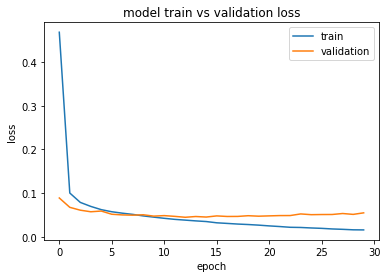

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

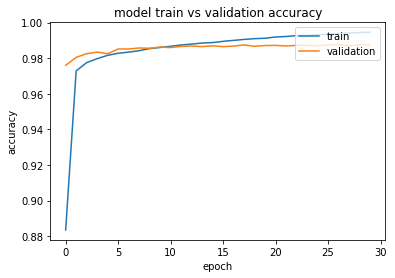

In [69]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [70]:
loss, acc = model.evaluate(X_dev_indices, Y_dev_oh)
print()
print("Dev accuracy = ", acc)

3150/3150 [==============================] - 26s 8ms/step

Dev accuracy =  0.98760265286


You should get a test accuracy of about 94.8% for a vanilla model using only aa1.txt.
A vanilla POS model on the full training set gets a dev accuracy of 98.50%!

In [24]:
X_dev_indices = lists_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_dev_indices)

# print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
# print(pd.crosstab(Y_dev, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_dev, pred)

NameError: name 'pd' is not defined

In [71]:
# This code allows you to see the mislabelled examples

y_dev_oh = to_categorical(Y_dev_indices, num_classes = numClasses)
X_dev_indices = lists_to_indices(X_dev, word_to_index, maxLen)
pred = model.predict(X_dev_indices)

correct = 0
wrong = 0


for i in range(len(X_dev)-1):
    for j in range(len(X_dev[i])):
        num = np.argmax(pred[i][j])
        if(num != Y_dev_indices[i][j]):
            wrong = wrong + 1
            print('Expected POS tag: '+ X_dev[i][j] + '|' + Y_dev[i][j] + ' prediction: '+ X_dev[i][j] + '|' + index_to_pos2[num])
        else:
            correct = correct + 1
total = wrong + correct
print("Total  : ", total)
print("Correct: ", correct)
print("Wrong  : ", wrong)

cpct = (100*correct)/total
wpct = (100*wrong)/total
print("Correct %: ", cpct)
print("Wrong   %: ", wpct)

Expected POS tag: toute|PRO:IND prediction: toute|ADV
Expected POS tag: découverts|NOM prediction: découverts|VER:pper
Expected POS tag: ainsi|ADV prediction: ainsi|KON
Expected POS tag: franc|NOM prediction: franc|ADJ
Expected POS tag: qu'|KON prediction: qu'|PRO:REL
Expected POS tag: amicale|ADJ prediction: amicale|NOM
Expected POS tag: en|PRP prediction: en|PRO:PER
Expected POS tag: droit|NOM prediction: droit|ADV
Expected POS tag: nonnes|NOM prediction: nonnes|ADJ
Expected POS tag: contrastés|VER:pper prediction: contrastés|ADJ
Expected POS tag: en|PRO:PER prediction: en|PRP
Expected POS tag: quelques-uns|PRO:IND prediction: quelques-uns|ADV
Expected POS tag: les|PRO:PER prediction: les|DET:ART
Expected POS tag: compte|VER:pres prediction: compte|NOM
Expected POS tag: ARD|NAM prediction: ARD|ABR
Expected POS tag: spécialisées|VER:pper prediction: spécialisées|ADJ
Expected POS tag: IDC|NAM prediction: IDC|ABR
Expected POS tag: portants|NOM prediction: portants|ADJ
Expected POS tag: 

Expected POS tag: que|PRO:REL prediction: que|ADV
Expected POS tag: que|ADV prediction: que|PRO:REL
Expected POS tag: en|PRO:PER prediction: en|PRP
Expected POS tag: exemplaire|ADJ prediction: exemplaire|NOM
Expected POS tag: en|PRO:PER prediction: en|PRP
Expected POS tag: net|ADV prediction: net|ADJ
Expected POS tag: un|NUM prediction: un|DET:ART
Expected POS tag: un|NUM prediction: un|DET:ART
Expected POS tag: vit|VER:pres prediction: vit|VER:simp
Expected POS tag: garde|VER:pres prediction: garde|NOM
Expected POS tag: majuscule|ADJ prediction: majuscule|NOM
Expected POS tag: qu'|KON prediction: qu'|PRO:REL
Expected POS tag: fort|ADJ prediction: fort|ADV
Expected POS tag: limitées|VER:pper prediction: limitées|ADJ
Expected POS tag: leur|PRO:PER prediction: leur|DET:POS
Expected POS tag: qu'|PRO:REL prediction: qu'|ADV
Expected POS tag: seul|ADV prediction: seul|ADJ
Expected POS tag: habilité|VER:pper prediction: habilité|NOM
Expected POS tag: vis|VER:pres prediction: vis|VER:simp
Exp

### POStagger results on development set

| tagset | LTSM units | batchnorm | dropout | epochs | results |
|:-----|---------:|:----------:|-------:|-----:|----------:|
| tt | 128 | no | 0 |  50 | 98.50 |
| tt | 128 | yes | 0.5 | 30 | 98.76 |


In [73]:
model.save('tt_pos.h5')

## 5. Training the Supertagger



### Prepare the training and development data

We split the data as before, only using Z (supertags) instead of Y2 (treetagger POStag set) as the goal

In [26]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_super_train, Y_super_testdev = train_test_split(X, Z, test_size=0.4)
X_test, X_dev, Y_super_test, Y_super_dev = train_test_split(X_testdev, Y_super_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)

Train:  (1195,)
Test:   (398,)
Dev:    (399,)


#### Prepare training data

Transform the training data into the form most convenient for the supertag model

In [27]:
X_train_indices = lists_to_indices(X_train, word_to_index, maxLen)
Y_super_train_indices = lists_to_indices(Y_super_train, super_to_index, maxLen)
Y_super_train_oh = to_categorical(Y_super_train_indices, num_classes=numSuperClasses)

#### Prepare development data

Do the same for the development data. The development data allows us to check for over/underfitting.

In [28]:
X_dev_indices = lists_to_indices(X_dev, word_to_index, max_len = maxLen)
Y_super_dev_indices = lists_to_indices(Y_super_dev, super_to_index, max_len = maxLen)
Y_super_dev_oh = to_categorical(Y_super_dev_indices, num_classes = numSuperClasses)

### Define the model

We define the structure of the model

In [29]:
# Super_model
# this is a direct supertag model not using the part-of-speech tags

def Super_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings) 
#    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    
    # Add a (time distributed) Dense layer followed by a softmax activation
    X = TimeDistributed(Dense(numSuperClasses, activation='softmax'))(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
        
    return model

In [30]:
supermodel = Super_model((maxLen,), word_to_vec_map, word_to_index)
supermodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 119)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 119, 663)          6648564   
_________________________________________________________________
lstm_2 (LSTM)                (None, 119, 128)          405504    
_________________________________________________________________
dropout_2 (Dropout)          (None, 119, 128)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 119, 518)          66822     
Total params: 7,120,890
Trainable params: 472,326
Non-trainable params: 6,648,564
_________________________________________________________________


In [31]:
supermodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
history = supermodel.fit(X_train_indices, Y_super_train_oh, epochs = 10, batch_size = 32, shuffle=True, validation_data=(X_dev_indices,Y_super_dev_oh))

Train on 1195 samples, validate on 399 samples
Epoch 1/10
1195/1195 [==============================] - 20s 17ms/step - loss: 1.0985 - acc: 0.7337 - val_loss: 1.0624 - val_acc: 0.7428
Epoch 2/10
1195/1195 [==============================] - 20s 17ms/step - loss: 1.0796 - acc: 0.7358 - val_loss: 1.0483 - val_acc: 0.7438
Epoch 3/10
1195/1195 [==============================] - 20s 17ms/step - loss: 1.0616 - acc: 0.7389 - val_loss: 1.0281 - val_acc: 0.7464
Epoch 4/10
1195/1195 [==============================] - 21s 17ms/step - loss: 1.0395 - acc: 0.7429 - val_loss: 1.0141 - val_acc: 0.7497
Epoch 5/10
1195/1195 [==============================] - 21s 17ms/step - loss: 1.0225 - acc: 0.7459 - val_loss: 1.0013 - val_acc: 0.7512
Epoch 6/10
1195/1195 [==============================] - 21s 17ms/step - loss: 1.0025 - acc: 0.7500 - val_loss: 0.9904 - val_acc: 0.7531
Epoch 7/10
1195/1195 [==============================] - 21s 18ms/step - loss: 0.9889 - acc: 0.7520 - val_loss: 0.9774 - val_acc: 0.7547
E

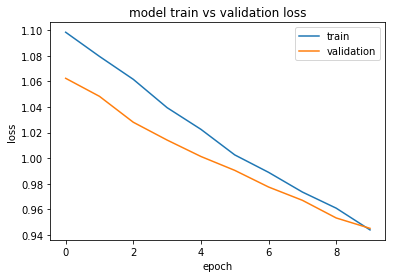

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

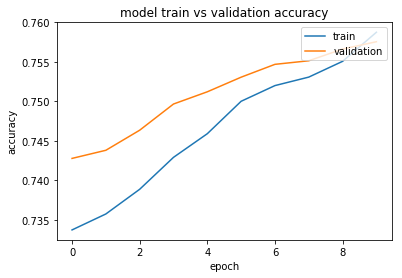

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
loss, acc = supermodel.evaluate(X_dev_indices, Y_super_dev_oh)
print()
print("Test accuracy = ", acc)

In [ ]:
supermodel.save('supertagger.h5')

### Supertagger results on development set

| LTSM units | batchnorm | dropout | epochs | results |
|---------:|:----------:|-------:|----:|----------:|
| 128 | yes | .2 |  50 | 80.21 |
| 256 | yes | .2 |  50 | |

In [42]:
tag_sequence("yves acceptera le lait", model, word_to_index, index_to_pos2, maxLen)

yves|NOM acceptera|VER:futu le|DET:ART lait|NOM 

In [43]:
tag_sequence("yves acceptera le lait", superposmodel, word_to_index, index_to_super, maxLen)

NameError: name 'superposmodel' is not defined

In [ ]:
print_tagged(X_dev, model, word_to_index, index_to_pos2, maxLen)

In [ ]:
print_tagged(X_dev[1:5], supermodel, word_to_index, index_to_super, maxLen)

In [ ]:
print_tagged_beta(X_dev[1:4], superposmodel, 0.1, word_to_index, index_to_super, maxLen)

In [ ]:
eval_beta(X_dev, Y_super_dev, supermodel, word_to_index, super_to_index, index_to_super, 0.01, maxLen)

## Combined part-of-speech and supertagger

### Prepare training and development data

In [74]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_super_train, Y_super_testdev = train_test_split(X, Z, test_size=0.4)
X_test, X_dev, Y_super_test, Y_super_dev = train_test_split(X_testdev, Y_super_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)

Train:  (9449,)
Test:   (3150,)
Dev:    (3150,)


In [75]:
X_train_indices = lists_to_indices(X_train, word_to_index, maxLen)
Y_super_train_indices = lists_to_indices(Y_super_train, super_to_index, maxLen)
Y_super_train_oh = to_categorical(Y_super_train_indices, num_classes=numSuperClasses)

In [76]:
X_dev_indices = lists_to_indices(X_dev, word_to_index, max_len = maxLen)
Y_super_dev_indices = lists_to_indices(Y_super_dev, super_to_index, max_len = maxLen)
Y_super_dev_oh = to_categorical(Y_super_dev_indices, num_classes = numSuperClasses)

### Define and train the model

In [77]:
# Super_model
# this is a direct supertag model not using the part-of-speech tags

def Super_pos_model(input_shape, pos_model, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # get probability distribution over parts_of_speech from pos_model
    parts_of_speech = pos_model(sentence_indices)
    
    # concatenate with the embeddings
    merged = concatenate([parts_of_speech,embeddings])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=True)(merged) 
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    
    # Add a (time distributed) Dense layer followed by a softmax activation
    X = TimeDistributed(Dense(numSuperClasses, activation='softmax'))(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
        
    return model

In [78]:
superposmodel = Super_pos_model((maxLen,), model, word_to_vec_map, word_to_index)
superposmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 266)          0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 266, 32)      24006314    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 266, 663)     23596170    input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 266, 695)     0           model_4[1][0]                    
                                                                 embedding_7[0][0]                
__________

In [79]:
superposmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = superposmodel.fit(X_train_indices, Y_super_train_oh, epochs = 20, batch_size = 32, shuffle=True, validation_data=(X_dev_indices,Y_super_dev_oh))

Train on 9449 samples, validate on 3150 samples
Epoch 1/20
9449/9449 [==============================] - 805s 85ms/step - loss: 1.6294 - acc: 0.6710 - val_loss: 0.8397 - val_acc: 0.7775
Epoch 2/20
9449/9449 [==============================] - 804s 85ms/step - loss: 0.8677 - acc: 0.7728 - val_loss: 0.7320 - val_acc: 0.7970
Epoch 3/20
9449/9449 [==============================] - 821s 87ms/step - loss: 0.7731 - acc: 0.7884 - val_loss: 0.6824 - val_acc: 0.8069
Epoch 4/20
9449/9449 [==============================] - 812s 86ms/step - loss: 0.7251 - acc: 0.7976 - val_loss: 0.6678 - val_acc: 0.8097
Epoch 5/20
9449/9449 [==============================] - 818s 87ms/step - loss: 0.6920 - acc: 0.8045 - val_loss: 0.6426 - val_acc: 0.8157
Epoch 6/20
9449/9449 [==============================] - 807s 85ms/step - loss: 0.6665 - acc: 0.8096 - val_loss: 0.6327 - val_acc: 0.8171
Epoch 7/20
9449/9449 [==============================] - 810s 86ms/step - loss: 0.6454 - acc: 0.8134 - val_loss: 0.6206 - val_acc: 

### Output progress

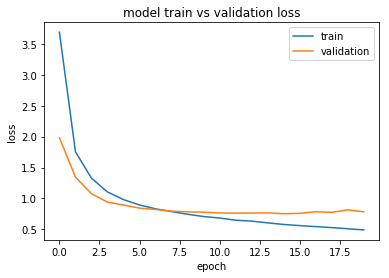

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

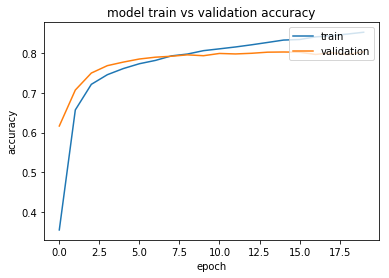

In [52]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
superposmodel.save('superpostagger.h5')